# ***Read CSV and load packages***

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
import time as tm
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import requests
import json

In [2]:
df_EV = pd.read_csv('EV_Weather.csv')
df_EV['Date'] = pd.to_datetime(df_EV['Date'], format='%Y-%m-%d %H:%M:%S')

In [3]:
df_test = df_EV.drop(columns = ['Unnamed: 0','CarsCharging','Temp_F','Windspeed_Kmph','Weather_Code','Humidity','Cloudcover','HeatIndexC','FeelsLikeC','Hourly_uvIndex','DewPointC','Visibility','WeatherDesc'])
df_EV.drop(columns = ['Unnamed: 0','CarsCharging','WeatherDesc'],inplace = True)

# ***Creating a feature capturing the rain fall of the previous n hours***

In [4]:
# Build a loop that creates 12 new features, each feature being a type of lagged version of the 'PrecipMM' (precipitation) feature.
# Each feature n counts the number of hours, in the last n hours, for which rainfall was greater than 0
n_values = range(1,13)

for n in n_values:
    new_column_name = f'Precip_{n}'
    df_test[new_column_name] = 0

    for i in range(n + 1):
        df_test[new_column_name] += (df_test['PrecipMM'].shift(i) > 0).astype(int)
        df_test[new_column_name] = df_test[new_column_name].clip(0, n+1)

<ipython-input-5-790a22aca812>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_test.corr()


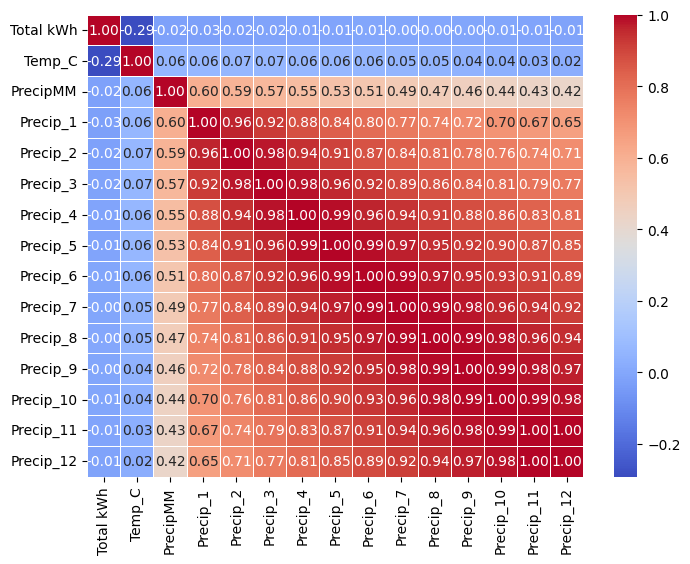

In [5]:
correlation_matrix = df_test.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

Unfortunately, these 12 lagged precipitation features seem to be irrelevant, since their correlation is close to zero.
The lagged features of the 'rain' feature will therefore not be included in the dataframe.

In [6]:
df_test.drop(columns = ['PrecipMM', 'Precip_1', 'Precip_2', 'Precip_3', 'Precip_4', 'Precip_5', 'Precip_6', 'Precip_7', 'Precip_8', 'Precip_9', 'Precip_10', 'Precip_11', 'Precip_12'], inplace = True)

# ***Hourly Feature***

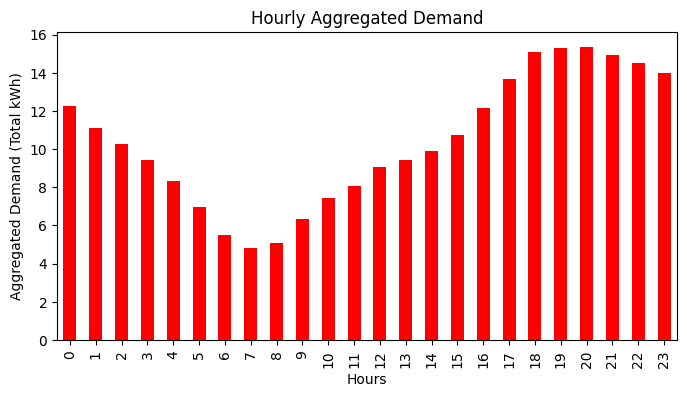

In [7]:
df_EV['Hours'] = df_EV['Date'].dt.hour
hourly_aggregated_demand = df_EV.groupby('Hours')['Total kWh'].mean()

plt.figure(figsize=(8, 4))
hourly_aggregated_demand.plot(kind='bar', color='red')
plt.xlabel('Hours')
plt.ylabel('Aggregated Demand (Total kWh)')
plt.title('Hourly Aggregated Demand')
plt.show()

We can identify that the off-peak hour for EV charging is 7am (i.e. 7am-8am)

Now create a feature that measures the proximity to the off-peak hour

In [8]:
# Encode the new variable measuring the proximity to off-peakhours
df_EV['8to19'] = np.where((df_EV['Hours'] >= 8) & (df_EV['Hours'] <= 19), df_EV['Hours'] - 7, 0)
df_EV['0to6'] = np.where((df_EV['Hours']>=0) & (df_EV['Hours'] <= 6), 7 - df_EV['Hours'], df_EV['8to19'])
df_EV['Prox_OffPeak'] = np.where((df_EV['Hours']>=20)*(df_EV['Hours']<= 23), 31 - df_EV['Hours'], df_EV['0to6'])

df_EV.drop(columns = ['8to19','0to6','Hours'], inplace = True)

In [9]:
#Create a Winter dummy feature
df_EV['Winter'] = np.where((df_EV['Date'].dt.month >=4) & (df_EV['Date'].dt.month <= 9), 0, 1)

# ***Weekday Feature***

In [10]:
df_EV['Weekday'] = df_EV['Date'].dt.day_name()
# Creating a 'Weekday' feature turns each day Monday to Sunday into a number 1 to 7

In [11]:
weekday_mapping = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
df_EV['Weekday'] = df_EV['Weekday'].map(weekday_mapping)

# ***Feature Correlation***

<ipython-input-12-3a53bf75f67b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_EV.corr()


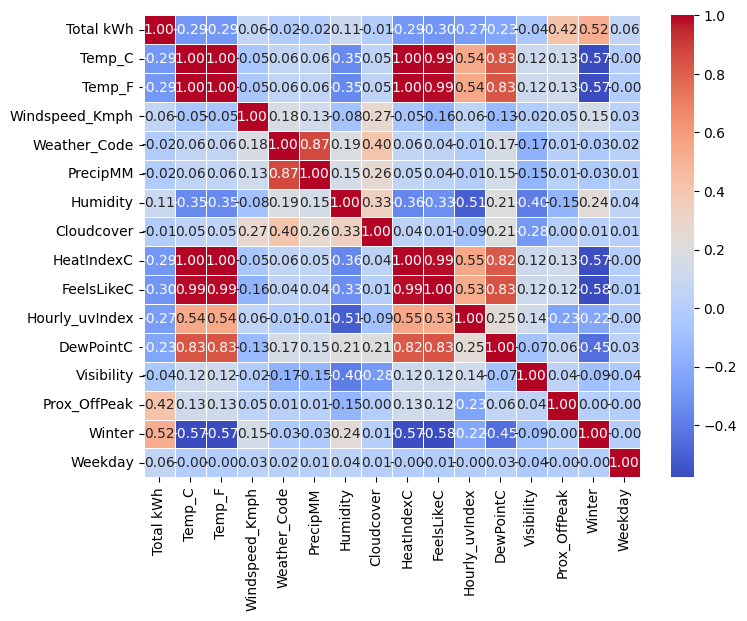

In [12]:
correlation_matrix = df_EV.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

# ***Feature Scaling***

In [13]:
import sklearn
from sklearn import preprocessing

In [14]:
coded = preprocessing.MinMaxScaler(feature_range=(0,1)) # defining the coding range 0 to 1
df_scaled = coded.fit_transform(df_EV.iloc[:,1:16])
#y_scaled = coded.fit_transform(df_EV.iloc[:,1:2])

df_scaled = pd.DataFrame(df_scaled, columns=['Total kWh','Temp_C','Temp_F',	'Windspeed_Kmph',	'Weather_Code',	'Humidity',	'Cloudcover',	'HeatIndexC',	'FeelsLikeC',	'Hourly_uvIndex',	'DewPointC',	'Visibility','Prox_OffPeak','Winter','Weekday'])  # Renaming the x-varaibles
#y_scaled = pd.DataFrame(y_scaled, columns=['Total kWh'])  # Renaming the y-varaible

df_scaled.head()

,Total kWh,Temp_C,Temp_F,Windspeed_Kmph,Weather_Code,Humidity,Cloudcover,HeatIndexC,FeelsLikeC,Hourly_uvIndex,DewPointC,Visibility,Prox_OffPeak,Winter,Weekday
0,0.000000,0.758621,0.735849,0.254545,0.000000,0.0,0.293333,0.15,0.793103,0.78125,0.833333,0.709677,1.0,0.500000,1.0
1,0.022401,0.758621,0.754717,0.254545,0.000000,0.0,0.280000,0.17,0.827586,0.78125,0.833333,0.709677,1.0,0.583333,1.0
2,0.044802,0.758621,0.735849,0.272727,0.000000,0.0,0.266667,0.18,0.793103,0.78125,0.833333,0.709677,1.0,0.666667,1.0
3,0.044802,0.724138,0.716981,0.236364,0.000000,0.0,0.333333,0.22,0.724138,0.75000,0.666667,0.709677,1.0,0.750000,1.0
4,0.044802,0.689655,0.679245,0.200000,0.012346,0.0,0.413333,0.25,0.689655,0.71875,0.666667,0.741935,1.0,0.833333,1.0


# ***Split data into train-validation-test set***

Train (80%), validation (10%), test (10%)
Due to the fact that this dataset is a time series, it is not possible to do a simple Cross Validation by randomly selecting data. Since we have to use past data to predict future data, the first 7019 hours (aprox. 9 months and 18 days) is used to train the data. The remaining last 1762 hours (aprox. 2months and 13days) is then split in half. The first half (aprox. 1month and 6 days) is the validation data, and the last half the final test data.

In [15]:
train_data = df_EV.iloc[0:7019] # about 80% of the data
x_train = df_EV.iloc[0:7019,2:17]
y_train = df_EV.iloc[0:7019,1:2]

val_data = df_EV.iloc[7019:7900] # about 10% of the data
x_val = df_EV.iloc[7019:7900,2:17]
y_val = df_EV.iloc[7019:7900,1:2]

test_data = df_EV.iloc[7900:8781] # about 10% of the data
x_test = df_EV.iloc[7900:8781,2:17]
y_test = df_EV.iloc[7900:8781,1:2]

# ***Feature Selection***

In [16]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [17]:
column_list = ['Temp_C', 'Temp_F', 'Windspeed_Kmph', 'Weather_Code', 'Humidity', 'Cloudcover', 'HeatIndexC', 'FeelsLikeC', 'Hourly_uvIndex', 'DewPointC', 'Visibility', 'Prox_OffPeak', 'Winter', 'Weekday']

In [19]:
#RFE with RandomForestRegressor
rfe2 = RFE(estimator=RandomForestRegressor(), n_features_to_select=1)
rfe2 = rfe2.fit(x_train, np.ravel(y_train))

#RFE with GradientBoostingRegressor
rfe3 = RFE(estimator=GradientBoostingRegressor(), n_features_to_select=1)
rfe3 = rfe3.fit(x_train, np.ravel(y_train))

In [20]:
# RFE with DecisionTree
rfe5 = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=1)
rfe5 = rfe5.fit(x_train, np.ravel(y_train))

print('\nDecisionTreeRegressor')
for i in range(len(column_list)):
    print('Column: %s, Selected %s, Rank: %.2f' % (column_list[i], rfe5.support_[i], rfe5.ranking_[i]))


DecisionTreeRegressor
Column: Temp_C, Selected False, Rank: 14.00
Column: Temp_F, Selected False, Rank: 5.00
Column: Windspeed_Kmph, Selected False, Rank: 4.00
Column: Weather_Code, Selected False, Rank: 15.00
Column: Humidity, Selected False, Rank: 12.00
Column: Cloudcover, Selected False, Rank: 3.00
Column: HeatIndexC, Selected False, Rank: 6.00
Column: FeelsLikeC, Selected False, Rank: 10.00
Column: Hourly_uvIndex, Selected False, Rank: 9.00
Column: DewPointC, Selected False, Rank: 11.00
Column: Visibility, Selected False, Rank: 8.00
Column: Prox_OffPeak, Selected False, Rank: 13.00
Column: Winter, Selected False, Rank: 2.00
Column: Weekday, Selected True, Rank: 1.00


In [22]:
column_list = ['Temp_C', 'Temp_F', 'Windspeed_Kmph', 'Weather_Code', 'Humidity', 'Cloudcover', 'HeatIndexC', 'FeelsLikeC', 'Hourly_uvIndex', 'DewPointC', 'Visibility', 'Prox_OffPeak', 'Winter', 'Weekday']

print('\nRandomForestRegressor')
for i in range(len(column_list)):
    print('Column: %s, Selected %s, Rank: %.2f' % (column_list[i], rfe2.support_[i], rfe2.ranking_[i]))

print('\nGradientBoostingRegressor')
for i in range(len(column_list)):
    print('Column: %s, Selected %s, Rank: %.2f' % (column_list[i], rfe3.support_[i], rfe3.ranking_[i]))


RandomForestRegressor
Column: Temp_C, Selected False, Rank: 12.00
Column: Temp_F, Selected False, Rank: 2.00
Column: Windspeed_Kmph, Selected False, Rank: 6.00
Column: Weather_Code, Selected False, Rank: 11.00
Column: Humidity, Selected False, Rank: 15.00
Column: Cloudcover, Selected True, Rank: 1.00
Column: HeatIndexC, Selected False, Rank: 5.00
Column: FeelsLikeC, Selected False, Rank: 10.00
Column: Hourly_uvIndex, Selected False, Rank: 9.00
Column: DewPointC, Selected False, Rank: 13.00
Column: Visibility, Selected False, Rank: 8.00
Column: Prox_OffPeak, Selected False, Rank: 14.00
Column: Winter, Selected False, Rank: 3.00
Column: Weekday, Selected False, Rank: 4.00

GradientBoostingRegressor
Column: Temp_C, Selected False, Rank: 9.00
Column: Temp_F, Selected False, Rank: 3.00
Column: Windspeed_Kmph, Selected False, Rank: 8.00
Column: Weather_Code, Selected False, Rank: 15.00
Column: Humidity, Selected False, Rank: 14.00
Column: Cloudcover, Selected False, Rank: 7.00
Column: HeatI

### **Selecting the Top 6 features for each methods according to RFE**

In [23]:
# RFE top feature selection for Random Forest
x_RF = x_train[['Temp_F', 'Windspeed_Kmph', 'Cloudcover','HeatIndexC','Winter','Weekday']]
x_RF_val = x_val[['Temp_F', 'Windspeed_Kmph', 'Cloudcover','HeatIndexC','Winter','Weekday']]
x_RF_test = x_test[['Temp_F', 'Windspeed_Kmph', 'Cloudcover','HeatIndexC','Winter','Weekday']]

In [24]:
# RFE top feature selection for Gradient Boosting
x_GB = x_train[['Temp_F','Cloudcover','Hourly_uvIndex','Visibility','Winter','Weekday']]
x_GB_val = x_val[['Temp_F','Cloudcover','Hourly_uvIndex','Visibility','Winter','Weekday']]
x_GB_test = x_test[['Temp_F','Cloudcover','Hourly_uvIndex','Visibility','Winter','Weekday']]

In [25]:
# RFE top feature selection for Decision Tree
x_DT = x_train[['Weekday' , 'Winter' , 'Cloudcover' , 'Windspeed_Kmph' , 'Temp_F' , 'HeatIndexC']]
x_DT_val = x_val[['Weekday' , 'Winter' , 'Cloudcover' , 'Windspeed_Kmph' , 'Temp_F' , 'HeatIndexC']]
x_DT_test = x_test[['Weekday' , 'Winter' , 'Cloudcover' , 'Windspeed_Kmph' , 'Temp_F' , 'HeatIndexC']]

# ***Grid Search***

### **3 Models Grid Search**

In [ ]:
from itertools import product

In [ ]:
# Random Forest Grid values
min_samples_leaf = [2,4,6,8,10,15,20,22,24,26,28,30,32,34,36,38,40,50]
max_depths = [3,4,5,6,7,8,9,10,11,12,13,14,15]
# Empty dataframe for the evaluation
rf_grid = pd.DataFrame(index = max_depths, columns = min_samples_leaf)

for min_sample, max_depth1 in product(min_samples_leaf, max_depths):
    rf_regressor = RandomForestRegressor(min_samples_leaf = min_sample , max_depth = max_depth1 ,n_estimators = 100, random_state = 1)
    rf_regressor.fit(x_RF, y_train.values.ravel())
    rf_prediction = rf_regressor.predict(x_RF_val)
    rf_grid.loc[max_depth1, min_sample] = mean_squared_error(y_val, rf_prediction)
rf_grid

,2,4,6,8,10,15,20,22,24,26,28,30,32,34,36,38,40,50
3,67.637381,67.637381,67.642866,67.642866,67.642866,67.665498,67.644761,67.665243,67.649658,67.701812,67.791544,67.891513,68.00091,68.074877,68.088009,68.097802,68.108102,68.130936
4,67.962762,67.96811,67.89583,67.867136,67.973261,67.897478,67.87769,67.898667,67.861435,67.867684,67.866085,67.92845,68.004021,68.068409,68.083367,68.082779,68.089762,68.246924
5,69.032468,69.073667,69.040283,68.844773,68.805465,68.550366,68.48193,68.491552,68.420889,68.416958,68.500486,68.641345,68.794405,68.791769,68.835295,68.796429,68.8605,69.176381
6,69.470412,69.627998,69.568561,69.391951,69.256201,69.034398,68.970032,69.037556,68.943889,68.815052,68.888483,68.917589,69.151346,69.149436,69.083868,69.061148,69.212417,69.443517
7,69.978708,69.933201,69.823905,69.794717,69.70586,69.731617,69.828377,69.720454,69.544831,69.30677,69.440472,69.541962,69.817438,69.824512,69.81314,69.713507,69.805724,69.797391
8,70.203231,70.225526,69.934674,70.085985,69.933872,69.799321,70.078935,70.055192,69.778128,69.456133,69.462986,69.634077,69.811905,69.967336,69.903382,69.820105,69.804265,69.896812
9,70.71671,70.550054,70.338733,70.318305,70.053199,70.025371,70.008193,70.145493,69.828242,69.605701,69.582767,69.817964,69.983255,70.150293,70.113908,69.957315,69.961693,70.01266
10,71.07012,70.884395,70.484573,70.419058,70.32186,69.977771,70.123827,70.286173,69.963389,69.689848,69.697648,69.929993,70.084117,70.238084,70.140201,70.025918,70.050084,70.060289
11,72.517081,71.506353,71.067982,70.859104,70.687684,70.107077,70.264524,70.478065,70.083892,69.813899,69.81795,70.055065,70.166696,70.282649,70.137594,70.031725,70.063397,70.068022
12,72.910167,72.309246,71.554438,71.117136,70.76684,70.167608,70.305503,70.524664,70.144321,69.851183,69.857829,70.096568,70.154654,70.276258,70.136579,70.02438,70.055196,70.067764


In [ ]:
# Gradient Boosting Grid values
learning_rates = [0.1, 0.2, 0.3, 0.4,0.5,0.6, 0.7,0.8, 0.9, 1,1.1, 1.2,1.4,1.5,2]
n_estimators = [10,20, 30,40, 50,60, 70,80, 90,95, 100,105,110, 120,130, 140,150,160, 170,180,190, 200]
# Empty dataframe for the evaluation
gb_grid = pd.DataFrame(index = n_estimators, columns = learning_rates)

for learning_rate1, n_estimator in product(learning_rates, n_estimators):
    gb_regressor = GradientBoostingRegressor(learning_rate = learning_rate1 , n_estimators = n_estimator, random_state = 1)
    gb_regressor.fit(x_GB, y_train.values.ravel())
    gb_prediction = gb_regressor.predict(x_GB_val)
    gb_grid.loc[n_estimator, learning_rate1] = mean_squared_error(y_val, gb_prediction)
gb_grid

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.4,1.5,2.0
10,78.131827,66.346043,64.021448,63.455676,61.979538,61.819435,60.248803,62.790899,61.147963,63.038629,62.132881,62.637108,71.501409,68.209891,122.92812
20,67.097832,62.846391,62.031768,61.672936,62.06559,65.073908,60.921645,64.536132,62.10375,61.894513,61.805779,65.643299,67.486999,65.892383,122.92812
30,63.988218,61.732948,62.003196,60.481479,63.088647,63.650261,61.84826,66.465334,65.462167,63.489104,65.947233,72.437863,70.828809,66.724979,122.92812
40,63.226757,61.29978,62.558914,60.667469,63.119166,63.729953,62.202546,65.235214,64.749404,65.576053,67.299119,77.52986,76.174146,65.992447,122.92812
50,62.616879,61.099232,61.734831,61.067582,65.017356,63.743441,63.370934,65.45359,64.601427,69.439458,69.214428,77.201951,69.639438,67.693125,122.92812
60,62.463895,60.949208,61.964006,62.647916,64.946889,65.622644,64.136089,67.0116,64.537282,69.282394,67.802888,79.180632,70.083107,67.891733,122.92812
70,62.168367,61.37016,62.03729,62.784559,64.861297,65.627273,64.805163,67.126328,66.073746,70.596476,68.71099,77.31653,70.89638,71.812689,122.92812
80,61.883585,61.458229,62.591939,63.675394,65.325373,66.091137,65.436464,67.257706,66.645591,73.736263,69.494831,77.470282,72.101165,75.634047,122.92812
90,61.778538,61.569872,63.44295,63.600645,65.893163,66.247071,66.471131,67.61026,67.374374,75.132237,69.749274,75.974476,71.121852,76.393893,122.92812
95,61.783824,61.203435,63.490748,64.399277,66.032395,66.276997,66.339034,67.807815,67.024717,75.27727,70.646617,76.796147,72.57841,75.871989,58.007487


In [ ]:
# Decision Tree Grid values
min_samples_leaf_DT = [2,4,8,10,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,100]
max_depths_DT = [1,2,3,4,8,10,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,100]
# Empty dataframe for the evaluation
DT_grid = pd.DataFrame(index = max_depths_DT, columns = min_samples_leaf_DT)

for min_sample_DT, max_depth_DT in product(min_samples_leaf_DT, max_depths_DT):
    DT_regressor = DecisionTreeRegressor(min_samples_leaf = min_sample_DT , max_depth = max_depth_DT , random_state = 1)
    DT_regressor.fit(x_DT, y_train.values.ravel())
    DT_prediction = DT_regressor.predict(x_DT_val)
    DT_grid.loc[max_depth_DT, min_sample_DT] = mean_squared_error(y_val, DT_prediction)
DT_grid

,2,4,8,10,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,100
1,72.530635,72.530635,72.530635,72.530635,72.530635,72.530635,72.530635,72.530635,72.530635,72.530635,72.530635,72.530635,72.530635,72.530635,72.530635,72.530635,72.530635,72.530635,72.530635,72.530635
2,67.855355,67.855355,67.855355,67.855355,67.855355,67.855355,67.855355,67.855355,67.855355,67.855355,67.855355,67.855355,67.855355,67.855355,67.855355,67.855355,67.855355,67.855355,67.855355,67.855355
3,68.532333,68.532333,68.532333,68.532333,68.532333,68.532333,68.532333,68.532333,68.532333,68.532333,68.532333,68.532333,68.532333,68.532333,68.532333,68.532333,68.532333,68.532333,68.532333,68.532333
4,69.420212,69.420212,69.420212,69.420212,69.445276,69.445276,69.482731,70.515535,70.515535,70.467706,70.467706,70.467706,70.135638,70.137494,69.901058,69.901058,70.064284,70.042627,70.04108,69.766528
8,79.572709,79.399684,79.75881,79.797346,76.561526,75.154754,75.069771,74.613385,75.398733,74.948458,74.001235,72.566116,73.193943,71.192278,71.972083,70.916244,71.591099,72.534969,72.978837,71.388046
10,92.876784,94.895589,89.589211,90.03078,85.062164,79.609619,79.555099,77.72651,78.108694,75.211606,73.886444,71.614335,73.219049,71.160191,71.939997,70.884158,71.591658,72.535528,72.978837,71.388046
20,117.585181,103.118836,95.281544,91.179254,85.631565,79.08803,80.070524,77.705504,78.026749,75.736647,74.892667,72.533656,73.219049,71.160191,71.939997,70.884158,71.591658,72.535528,72.978837,71.388046
25,118.992194,102.558886,95.276364,91.179254,85.631565,79.08803,80.070524,77.705504,78.026749,75.736647,74.892667,72.533656,73.219049,71.160191,71.939997,70.884158,71.591658,72.535528,72.978837,71.388046
30,118.992194,102.558886,95.276364,91.179254,85.631565,79.08803,80.070524,77.705504,78.026749,75.736647,74.892667,72.533656,73.219049,71.160191,71.939997,70.884158,71.591658,72.535528,72.978837,71.388046
35,118.992194,102.558886,95.276364,91.179254,85.631565,79.08803,80.070524,77.705504,78.026749,75.736647,74.892667,72.533656,73.219049,71.160191,71.939997,70.884158,71.591658,72.535528,72.978837,71.388046


#### ***3 Best Models after Hyperparameter Tuning***

Min MSE for GradientBoosting: 58.007487 with parameters: learning_rate = 2.0, n_estimators = 95 or 105

Min MSE for DecisionTree: 67.855355 with parameters: min_samples_leaf = 4 , max_depth = 2

Min MSE for RandomForest: 67.637381 with paratmeters: min_samples_leaf = 2 , max_depth = 3

### **The 3 Best Models**

In [18]:
# Min MSE for GradientBoosting: 58.007487 with parameters: learning_rate = 2.0, n_estimators = 95 or 105
# Min MSE for DecisionTree: 67.855355 with parameters: min_samples_leaf = 4 , max_depth = 2
# Min MSE for RandomForest: 67.637381 with paratmeters: min_samples_leaf = 2 , max_depth = 3

#### **Mean Squared Error Evaluation on Final Test Data**

In [ ]:
# Random Forest Regressor
rf1_regressor = RandomForestRegressor(min_samples_leaf = 2 , max_depth = 3, n_estimators=100, random_state=1)
rf1_regressor.fit(x_RF, y_train)
rf1_prediction = rf1_regressor.predict(x_RF_test)
rf1_mse = mean_squared_error(y_test, rf1_prediction)

# GradientBoosting regressor,
gb1_regressor = GradientBoostingRegressor(learning_rate = 2.0, n_estimators = 95, random_state = 1)
gb1_regressor.fit(x_GB, y_train)
gb1_predictions = gb1_regressor.predict(x_GB_test)
GB1_mse = mean_squared_error(y_test, gb1_predictions)

# DecisionTree regressor
DT1_regressor = DecisionTreeRegressor(min_samples_leaf = 4 , max_depth = 2 , random_state = 1)
DT1_regressor.fit(x_DT, y_train)
DT1_predictions = DT1_regressor.predict(x_DT_test)
DT1_mse = mean_squared_error(y_test, DT1_predictions)

print('\nResults on test dataset:')
print('Best Random Forest MSE:', rf1_mse)
print('Best Gradient Boosting MSE:', GB1_mse)
print('Best Decision Tree MSE:',DT1_mse)

<ipython-input-236-26c9569423ce>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf1_regressor.fit(x_RF, y_train)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Results on test dataset:
Best Random Forest MSE: 89.34321284834778
Best Gradient Boosting MSE: 68.34687797880588
Best Decision Tree MSE: 89.04721725097684


In [ ]:
# Evaluation on training data (this is the result of overfitting)
rf1_prediction_train = rf1_regressor.predict(x_RF)
rf1_mse_train = mean_squared_error(y_train, rf1_prediction_train)

gb1_predictions_train = gb1_regressor.predict(x_GB)
GB1_mse_train = mean_squared_error(y_train, gb1_predictions_train)

DT1_predictions_train = DT1_regressor.predict(x_DT)
DT1_mse_train = mean_squared_error(y_train, DT1_predictions_train)

print('Evaluation on training data (this is the result of overfitting):')
print('Best Random Forest MSE:',rf1_mse_train)
print('Best Gradient Boosting MSE:',GB1_mse_train)
print('Best Decision Tree MSE:',DT1_mse_train)

Evaluation on training data (this is the result of overfitting):
Best Random Forest MSE: 34.177174775954356
Best Gradient Boosting MSE: 46.68767620038102
Best Decision Tree MSE: 35.20689541203188


In [ ]:
#This is the base model, measuring the base level of performance by simply predicting the average for every observation
df_base = pd.DataFrame(y_train['Total kWh'].mean() ,index = range(len(y_test)), columns = ['Total kWh'])
df_base_train = pd.DataFrame(y_train['Total kWh'].mean() ,index = range(len(y_train)), columns = ['Total kWh'])
Base_mse = mean_squared_error(y_test, df_base)
Base_mse_train = mean_squared_error(y_train,df_base_train)
print('Testing MSE:',Base_mse)
print('Training MSE:',Base_mse_train)

Testing MSE: 138.57506971866005
Training MSE: 46.68767620038129


#### **Root Mean Squared Error Evaluation on Final Test Data**

In [ ]:
# RMSE results on test data:
rf1_rmse = mean_squared_error(y_test, rf1_prediction, squared=False)
GB1_rmse = mean_squared_error(y_test, gb1_predictions, squared=False)
DT1_rmse = mean_squared_error(y_test, DT1_predictions, squared=False)
Base_rmse = mean_squared_error(y_test, df_base, squared=False)
print('RMSE results on test dataset:')
print('Random Forest RMSE:', rf1_rmse)
print('Gradient Boosting RMSE:', GB1_rmse)
print('Decision Tree RMSE:',DT1_rmse)
print('Base Model RMSE:',Base_rmse)

RMSE results on test dataset:
Random Forest RMSE: 9.452153873501414
Gradient Boosting RMSE: 8.267217063728634
Decision Tree RMSE: 9.436483309526746
Base Model RMSE: 11.77179127060364


In [ ]:
# RMSE results on training data (subject to overfitting):
rf1_rmse_train = mean_squared_error(y_train, rf1_prediction_train, squared=False)
GB1_rmse_train = mean_squared_error(y_train, gb1_predictions_train, squared=False)
DT1_rmse_train = mean_squared_error(y_train, DT1_predictions_train, squared=False)
Base_rmse_train = mean_squared_error(y_train,df_base_train, squared=False)

print('RMSE results on training data (subject to overfitting):')
print('Random Forest RMSE:',rf1_rmse_train)
print('Gradient Boosting RMSE:',GB1_rmse_train)
print('Decision Tree RMSE:',DT1_rmse_train)
print('Base Model RMSE:',Base_rmse_train)

RMSE results on training data (subject to overfitting):
Random Forest RMSE: 5.846124765684903
Gradient Boosting RMSE: 6.832838078015681
Decision Tree RMSE: 5.933539871950966
Base Model RMSE: 6.8328380780157


In [ ]:
x_RF1 = x_train[['Prox_OffPeak','Temp_F', 'Windspeed_Kmph', 'Cloudcover','HeatIndexC','Winter','Weekday']]
x_RF_val1 = x_val[['Prox_OffPeak','Temp_F', 'Windspeed_Kmph', 'Cloudcover','HeatIndexC','Winter','Weekday']]

### **Plotting Model Evaluation**

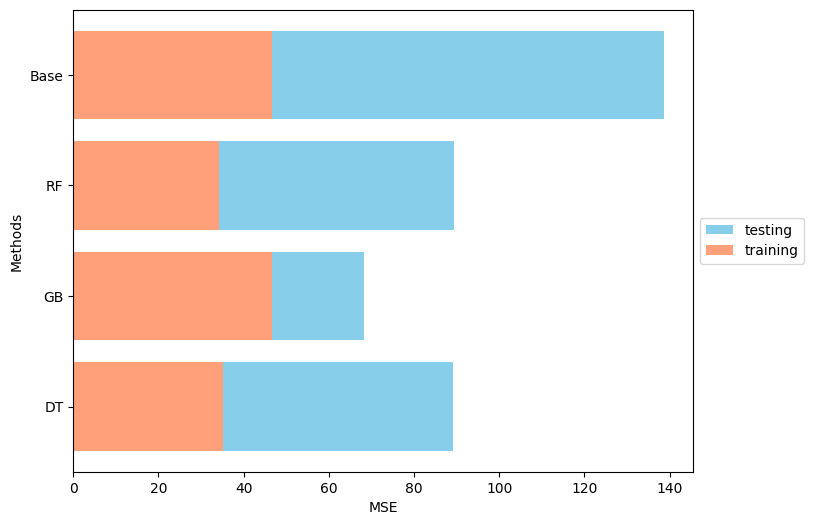

In [ ]:
# MSE Model Evaluation for all 3 methods using optimal parameters determined by grid search
model_names = ['DT', 'GB','RF', 'Base']
mse_test = [DT1_mse, GB1_mse, rf1_mse, Base_mse]
mse_train = [DT1_mse_train,GB1_mse_train,rf1_mse_train,Base_mse_train]

plt.figure(figsize=(8, 6))
plt.barh(model_names, mse_test, color='skyblue',label = 'testing')
plt.barh(model_names, mse_train, color='lightsalmon', label='training' )
plt.xlabel('MSE')
plt.ylabel('Methods')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('Model_MSE_Evaluation.png', bbox_inches='tight')
plt.show()


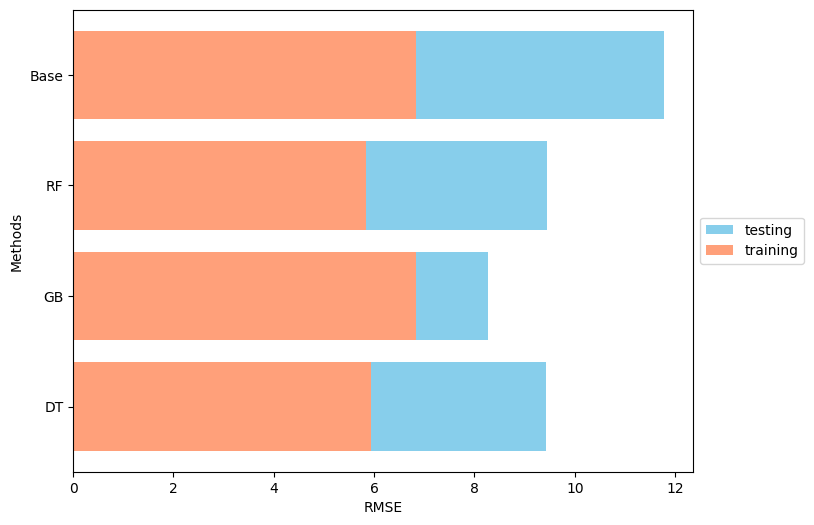

In [ ]:
# RMSE Model Evaluation for all 3 methods using optimal parameters determined by grid search
model_names = ['DT', 'GB','RF', 'Base']
mse_test = [DT1_rmse, GB1_rmse, rf1_rmse, Base_rmse]
mse_train = [DT1_rmse_train,GB1_rmse_train,rf1_rmse_train,Base_rmse_train]

plt.figure(figsize=(8, 6))
plt.barh(model_names, mse_test, color='skyblue',label = 'testing')
plt.barh(model_names, mse_train, color='lightsalmon', label='training' )
plt.xlabel('RMSE')
plt.ylabel('Methods')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('Model_RMSE_Evaluation.png', bbox_inches='tight')
plt.show()
